In [1]:
import gseapy as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dea_results = pd.read_csv(
    '../diffexp/tregs.tissue.scps.sat1.de.all.tsv',
    sep = '\t'
)

In [2]:
lfc_threshold = 0.25
gsea_results = []
for regulation in ['upregulated', 'downregulated']: 
    if regulation == 'upregulated':
        is_significant = (
            (dea_results.p_val_adj < 0.001) & 
            (dea_results.avg_log2FC > lfc_threshold)
        )

    else:
        is_significant = (
            (dea_results.p_val_adj < 0.001) & 
            (dea_results.avg_log2FC < -lfc_threshold)
        )

    gsea_result = gp.enrichr(
        gene_list = dea_results[is_significant].gene.to_list(),
        gene_sets = ['MSigDB_Hallmark_2020'],
        organism = 'Human',
        outdir = None
    ).results
    gsea_result['regulation'] = regulation
    gsea_results.append(gsea_result)

enrichment_results = pd.concat(gsea_results)
enrichment_results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,regulation
0,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,50/200,1.189043e-42,5.469598e-41,0,0,20.752929,2003.392790,BTG3;CDKN1A;BTG1;CD83;TNFAIP3;SLC2A3;SAT1;ZFP3...,upregulated
1,MSigDB_Hallmark_2020,Hypoxia,30/200,4.450951e-19,1.023719e-17,0,0,10.316375,435.928739,PPP1R15A;CDKN1A;BTG1;CXCR4;TNFAIP3;RORA;SLC2A3...,upregulated
2,MSigDB_Hallmark_2020,IL-2/STAT5 Signaling,29/199,3.973229e-18,6.092284e-17,0,0,9.942638,398.371216,PHTF2;CD83;RORA;SLC2A3;CST7;SYNGR2;CCND2;NFKBI...,upregulated
3,MSigDB_Hallmark_2020,mTORC1 Signaling,28/200,4.500300e-17,5.175346e-16,0,0,9.458868,356.029939,PPP1R15A;IDI1;CDKN1A;TFRC;INSIG1;UBE2D3;CXCR4;...,upregulated
4,MSigDB_Hallmark_2020,Apoptosis,24/161,1.950157e-15,1.794145e-14,0,0,10.076868,341.312263,BNIP3L;BTG3;JUN;CDKN1A;GADD45B;GADD45A;HMGB2;H...,upregulated
...,...,...,...,...,...,...,...,...,...,...,...
24,MSigDB_Hallmark_2020,G2-M Checkpoint,1/200,6.457826e-01,6.457826e-01,0,0,0.970440,0.424366,STMN1,downregulated
25,MSigDB_Hallmark_2020,Complement,1/200,6.457826e-01,6.457826e-01,0,0,0.970440,0.424366,LCK,downregulated
26,MSigDB_Hallmark_2020,Myc Targets V1,1/200,6.457826e-01,6.457826e-01,0,0,0.970440,0.424366,PABPC1,downregulated
27,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,1/200,6.457826e-01,6.457826e-01,0,0,0.970440,0.424366,IL32,downregulated


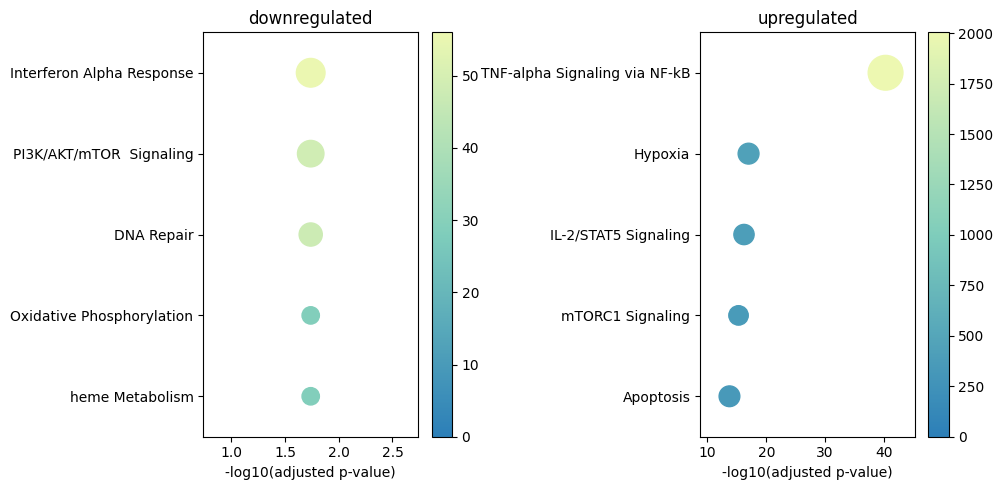

In [3]:
import matplotlib as mpl

from matplotlib.colors import LinearSegmentedColormap, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable


mpl.rcParams['pdf.fonttype'] = 42


def compute_percent_overlap(x):
    n_genes_in_overlap, n_genes_in_set = [int(i) for i in x.split('/')]
    return n_genes_in_overlap/n_genes_in_set * 100


cmap = LinearSegmentedColormap.from_list(
    'petrols',
    ['#edf8b1', '#7fcdbb', '#2c7fb8'][::-1],
    255
)

df = enrichment_results
regulated = {
    k: group for k, group in df.groupby('regulation')
}

fig, axs = plt.subplots(1, 2)
for ax, size, x_add, (key, df) in zip(axs, [5, 1], [1, 5], regulated.items()):
    df = df.sort_values(by = 'Adjusted P-value').head(n = 5)
    df['percent_overlap'] = df.Overlap.apply(
        compute_percent_overlap
    )
    df['-log10_padj'] = -np.log10(df['Adjusted P-value'])
    df.sort_values(
        by = ['-log10_padj', 'percent_overlap'], 
        ascending = False,
        inplace = True
    )
    log_combined_scores = df['Combined Score']
    cbar_max = np.ceil(log_combined_scores.max())
    norm = Normalize(0, cbar_max)
    y = range(len(df), 0, -1)
    x = -np.log10(df['Adjusted P-value'])
    ax.scatter(
        x = x,
        y = y,
        s = (df.percent_overlap * size) ** 2,
        c = cmap(norm(log_combined_scores))
    )
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    fig.colorbar(sm, ax = ax)
    ax.set_ylim(min(y) - 0.5, max(y) + 0.5)
    ax.set_xlim(min(x) - x_add, max(x) + x_add)
    ax.set_yticks(y)
    ax.set_yticklabels(df.Term)
    ax.set_xlabel('-log10(adjusted p-value)')
    ax.set_title(key)
    
fig.set_figwidth(10)
fig.set_figheight(5)
fig.tight_layout()
fig.savefig('../plots/tregs.tissue.scps.sat1.gsea.pdf')